# Face Detection Model for Video Privacy System

This notebook implements a machine learning model for detecting faces in videos as part of an adaptive face-blur privacy system.

## Overview
- Uses face images and ground truth bounding boxes/landmarks from YouTube dataset
- Trains a neural network to detect faces and predict bounding boxes + landmarks
- Provides inference capabilities for face detection in video frames

## Step 5: Create and Test Data Pipeline

In [1]:
# # Install required packages
# !pip install torch torchvision torchaudio
# !pip install pandas scikit-learn matplotlib pillow opencv-python numpy

## Step 6: Create Face Detection Model

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")

# Import our custom face detection model
from face_detection_model import *

print(f"Using device: {device}")
print("Libraries imported successfully!")

Face Detection Model loaded successfully!
Using device: cpu
Using device: cpu
Libraries imported successfully!


## Step 7: Visualize Sample Data

In [3]:
# Load and explore dataset from .npz files
import os
import glob

# Define data directories
data_base_dir = "/Users/adityasirohi/BlurBuddy/Data"
subdirs = [
    "youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1",
    "youtube_faces_with_keypoints_full_2/youtube_faces_with_keypoints_full_2", 
    "youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3",
    "youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4"
]

# Find all .npz files
npz_files = []
for subdir in subdirs:
    subdir_path = os.path.join(data_base_dir, subdir)
    files = glob.glob(os.path.join(subdir_path, "*.npz"))
    npz_files.extend(files)

print(f"Found {len(npz_files)} .npz files")

# Extract person names from filenames
person_names = []
for file_path in npz_files:
    filename = os.path.basename(file_path)
    # Extract person name (everything before the last underscore and number)
    person_name = '_'.join(filename.split('_')[:-1])
    person_names.append(person_name)

# Create a simple DataFrame-like structure
data_info = pd.DataFrame({
    'file_path': npz_files,
    'person_name': person_names
})

print(f"Dataset shape: {data_info.shape}")
print(f"Unique persons: {data_info['person_name'].nunique()}")

# Show top persons by sample count
person_counts = data_info['person_name'].value_counts()
print(f"\nTop 10 persons by sample count:")
print(person_counts.head(10))

# Show data distribution
print(f"\nDataset Info:")
print(f"- Total samples: {len(data_info)}")
print(f"- Unique persons: {data_info['person_name'].nunique()}")
print(f"- Avg samples per person: {len(data_info) / data_info['person_name'].nunique():.1f}")

# Store for later use
df = data_info

Found 2194 .npz files
Dataset shape: (2194, 2)
Unique persons: 828

Top 10 persons by sample count:
person_name
Lauren_Hutton          6
Robert_F_Kennedy_Jr    6
Kevin_Spacey           6
Alison_Lohman          6
Andrew_Bernard         5
Tavis_Smiley           5
Tara_VanDerveer        5
Fred_Eckhard           5
Amanda_Beard           5
Narendra_Modi          5
Name: count, dtype: int64

Dataset Info:
- Total samples: 2194
- Unique persons: 828
- Avg samples per person: 2.6


## Step 4: Sample Dataset for Local Training

In [5]:
# Sample 1/4th of the dataset for local training
print(f"Original dataset size: {len(df)} samples")

# Randomly sample 25% of the data for local training
df_sample = df.sample(n=int(len(df) * 0.25), random_state=42)

print(f"Sampled dataset size: {len(df_sample)} samples")
print(f"This is {len(df_sample)/len(df)*100:.1f}% of the original dataset")

# Show sample distribution by person
person_counts_sample = df_sample['person_name'].value_counts()
print(f"Sampled Dataset Info:")
print(f"- Total samples: {len(df_sample)}")
print(f"- Unique persons: {df_sample['person_name'].nunique()}")
print(f"- Avg samples per person: {len(df_sample) / df_sample['person_name'].nunique():.1f}")

# Store the sampled dataframe for later use
df = df_sample

Original dataset size: 2194 samples
Sampled dataset size: 548 samples
This is 25.0% of the original dataset
Sampled Dataset Info:
- Total samples: 548
- Unique persons: 424
- Avg samples per person: 1.3


## Step 4: Create and Test Data Pipeline

In [6]:
# Split dataset for face detection (we don't need person-based stratification)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Create datasets
data_dir = "/Users/adityasirohi/BlurBuddy/Data"
train_dataset = FaceDetectionDataset(train_df, data_dir)
val_dataset = FaceDetectionDataset(val_df, data_dir)
test_dataset = FaceDetectionDataset(test_df, data_dir)

# Test loading a sample
sample_image, sample_bbox, sample_landmarks = train_dataset[0]
print(f"\nSample data shapes:")
print(f"- Image: {sample_image.shape}")
print(f"- Bounding box: {sample_bbox.shape}")
print(f"- Landmarks: {sample_landmarks.shape}")
print(f"- Bbox values: {sample_bbox}")
print(f"- First few landmarks: {sample_landmarks[:10]}")

Train set: 383 samples
Validation set: 82 samples
Test set: 83 samples

Sample data shapes:
- Image: torch.Size([3, 224, 224])
- Bounding box: torch.Size([4])
- Landmarks: torch.Size([136])
- Bbox values: tensor([0.2544, 0.2995, 0.7811, 0.7295])
- First few landmarks: tensor([0.1006, 0.4444, 0.1183, 0.5169, 0.1361, 0.5797, 0.1538, 0.6232, 0.1953,
        0.6667])


## Step 8: Train Face Detection Model

In [7]:
# Create face detection model
model = FaceDetectionModel(num_landmarks=68).to(device)

print(f"Model created successfully")
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Test model with sample data
test_image = torch.zeros((1, 3, 224, 224)).to(device)

with torch.no_grad():
    bbox_output, landmarks_output = model(test_image)
    print(f"Bbox output shape: {bbox_output.shape}")
    print(f"Landmarks output shape: {landmarks_output.shape}")

Model created successfully
Total parameters: 2,164,236
Bbox output shape: torch.Size([1, 4])
Landmarks output shape: torch.Size([1, 136])


## Step 9: Visualize Model Predictions

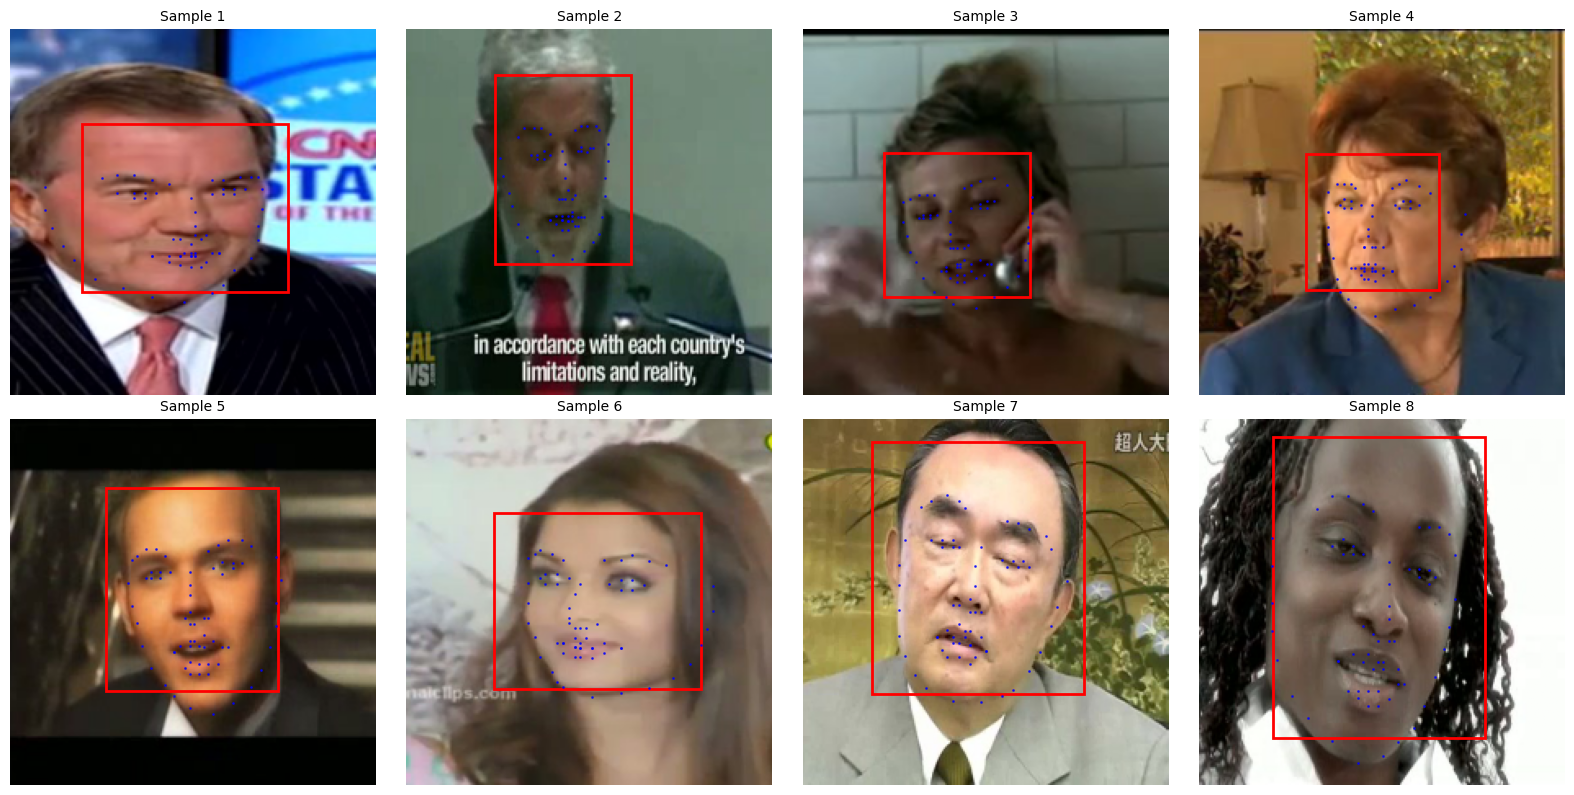


Shown 8 sample faces with bounding boxes and landmarks


In [8]:
# Visualize sample face detection data
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(min(8, len(train_dataset))):
    image, bbox, landmarks = train_dataset[i]
    
    # Convert image for display
    image_display = image.permute(1, 2, 0).cpu().numpy()
    
    # Denormalize coordinates
    h, w = image_display.shape[:2]
    bbox_denorm = bbox.cpu().numpy() * [w, h, w, h]
    landmarks_denorm = landmarks.cpu().numpy().reshape(68, 2) * [w, h]
    
    # Plot image
    axes[i].imshow(image_display)
    
    # Draw bounding box
    rect = patches.Rectangle(
        (bbox_denorm[0], bbox_denorm[1]), 
        bbox_denorm[2] - bbox_denorm[0], 
        bbox_denorm[3] - bbox_denorm[1],
        linewidth=2, edgecolor='red', facecolor='none'
    )
    axes[i].add_patch(rect)
    
    # Draw landmarks
    axes[i].scatter(landmarks_denorm[:, 0], landmarks_denorm[:, 1], 
                   c='blue', s=1, alpha=0.7)
    
    axes[i].set_title(f'Sample {i+1}', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
print(f"\nShown {min(8, len(train_dataset))} sample faces with bounding boxes and landmarks")

## Step 10: Training Progress Visualization

In [9]:
# Initialize training setup
criterion_bbox = nn.MSELoss()  # Mean Squared Error for bounding box regression
criterion_landmarks = nn.MSELoss()  # Mean Squared Error for landmarks regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, factor=0.5)

# Create data loaders
batch_size = 16  # Smaller batch size for face detection
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Training setup complete!")
print(f"Training in {len(train_loader)} batches of {batch_size} samples each")

# Training variables
best_val_loss = float('inf')
patience = 10
no_improve = 0
train_losses = []
val_losses = []
bbox_losses = []
landmarks_losses = []

print("\nStarting training...")
print("Note: This may take several minutes depending on your hardware")

# Training loop
for epoch in range(20):  # Reduced epochs for demonstration
    print(f"\nEpoch {epoch + 1}/20:")
    
    # Train
    train_loss, train_bbox_loss, train_landmarks_loss = train_epoch(
        model, train_loader, criterion_bbox, criterion_landmarks, optimizer, device
    )
    train_losses.append(train_loss)
    bbox_losses.append(train_bbox_loss)
    landmarks_losses.append(train_landmarks_loss)
    
    # Evaluate
    val_loss, val_bbox_loss, val_landmarks_loss = evaluate(
        model, val_loader, criterion_bbox, criterion_landmarks, device
    )
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} (Bbox: {train_bbox_loss:.4f}, Landmarks: {train_landmarks_loss:.4f})")
    print(f"Val Loss: {val_loss:.4f} (Bbox: {val_bbox_loss:.4f}, Landmarks: {val_landmarks_loss:.4f})")
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'epoch': epoch,
        }, 'face_detection_model.pth')
        no_improve = 0
        print(f"  -> Best model saved! (Val Loss: {val_loss:.4f})")
    else:
        no_improve += 1
    
    # Early stopping check
    if no_improve >= patience:
        print(f"  -> Early stopping triggered after {epoch + 1} epochs")
        break

print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

Training setup complete!
Training in 24 batches of 16 samples each

Starting training...
Note: This may take several minutes depending on your hardware

Epoch 1/20:
Batch 0/24, Total Loss: 0.0643, Bbox Loss: 0.0572, Landmarks Loss: 0.0143
Batch 10/24, Total Loss: 0.0121, Bbox Loss: 0.0096, Landmarks Loss: 0.0050
Batch 20/24, Total Loss: 0.0104, Bbox Loss: 0.0081, Landmarks Loss: 0.0046
Train Loss: 0.0165 (Bbox: 0.0136, Landmarks: 0.0059)
Val Loss: 0.0070 (Bbox: 0.0053, Landmarks: 0.0033)
  -> Best model saved! (Val Loss: 0.0070)

Epoch 2/20:
Batch 0/24, Total Loss: 0.0088, Bbox Loss: 0.0068, Landmarks Loss: 0.0039
Batch 10/24, Total Loss: 0.0089, Bbox Loss: 0.0071, Landmarks Loss: 0.0038
Batch 20/24, Total Loss: 0.0075, Bbox Loss: 0.0063, Landmarks Loss: 0.0023
Train Loss: 0.0082 (Bbox: 0.0063, Landmarks: 0.0037)
Val Loss: 0.0063 (Bbox: 0.0046, Landmarks: 0.0034)
  -> Best model saved! (Val Loss: 0.0063)

Epoch 3/20:
Batch 0/24, Total Loss: 0.0091, Bbox Loss: 0.0067, Landmarks Loss: 0.

## Step 8: Visualize Model Predictions

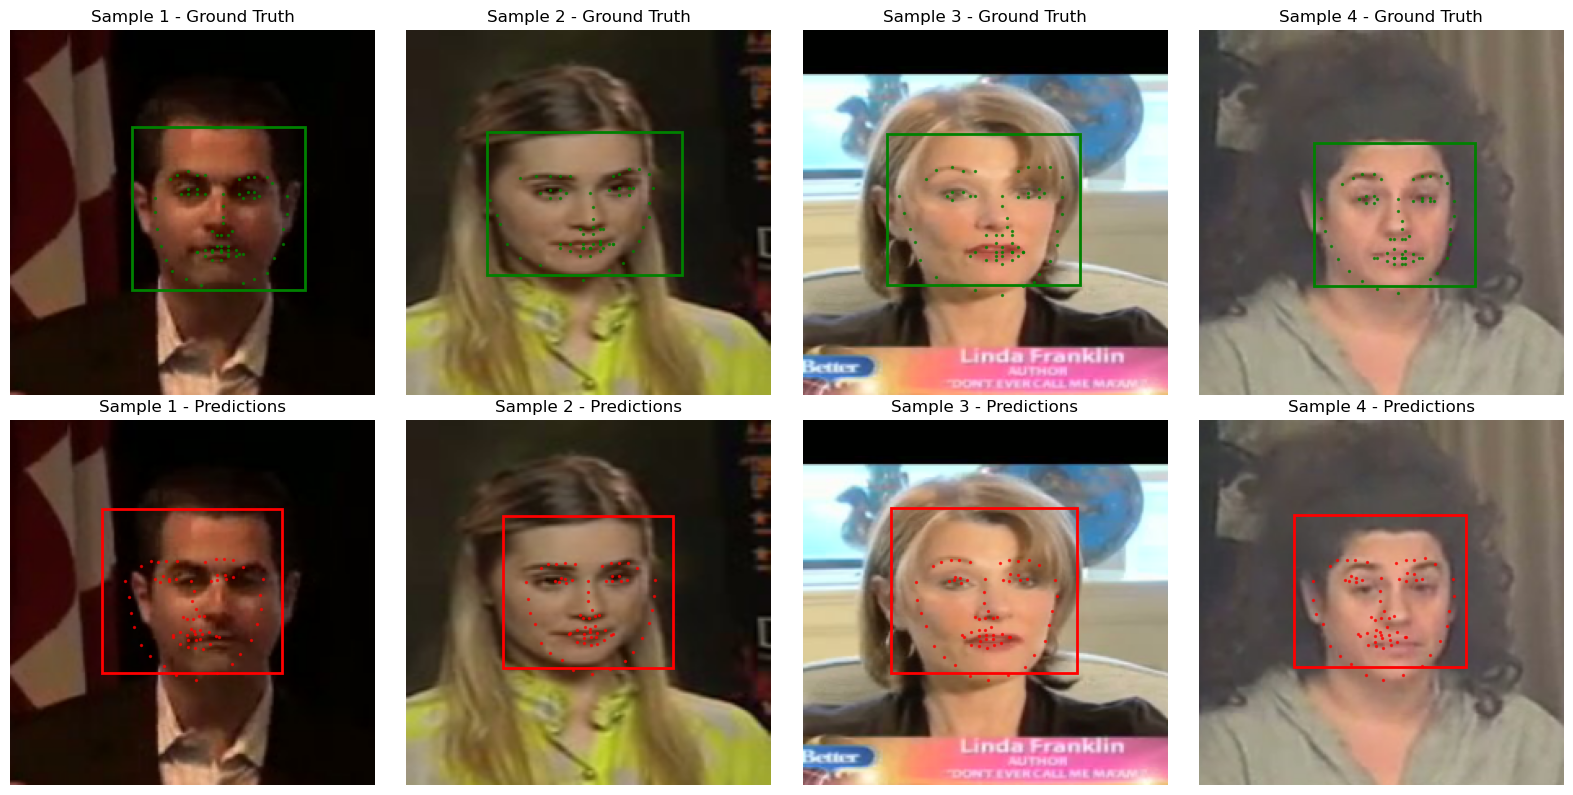

Model predictions visualized above!
Red boxes and dots = Model predictions
Green boxes and dots = Ground truth


In [10]:
# Load best model
if torch.cuda.is_available():
    checkpoint = torch.load('face_detection_model.pth')
else:
    checkpoint = torch.load('face_detection_model.pth', map_location='cpu')

model.load_state_dict(checkpoint['model_state_dict'])

# Visualize predictions on test set
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
visualize_predictions(model, test_loader, device, num_samples=4)

print("Model predictions visualized above!")
print("Red boxes and dots = Model predictions")
print("Green boxes and dots = Ground truth")

## Step 9: Training Progress Visualization

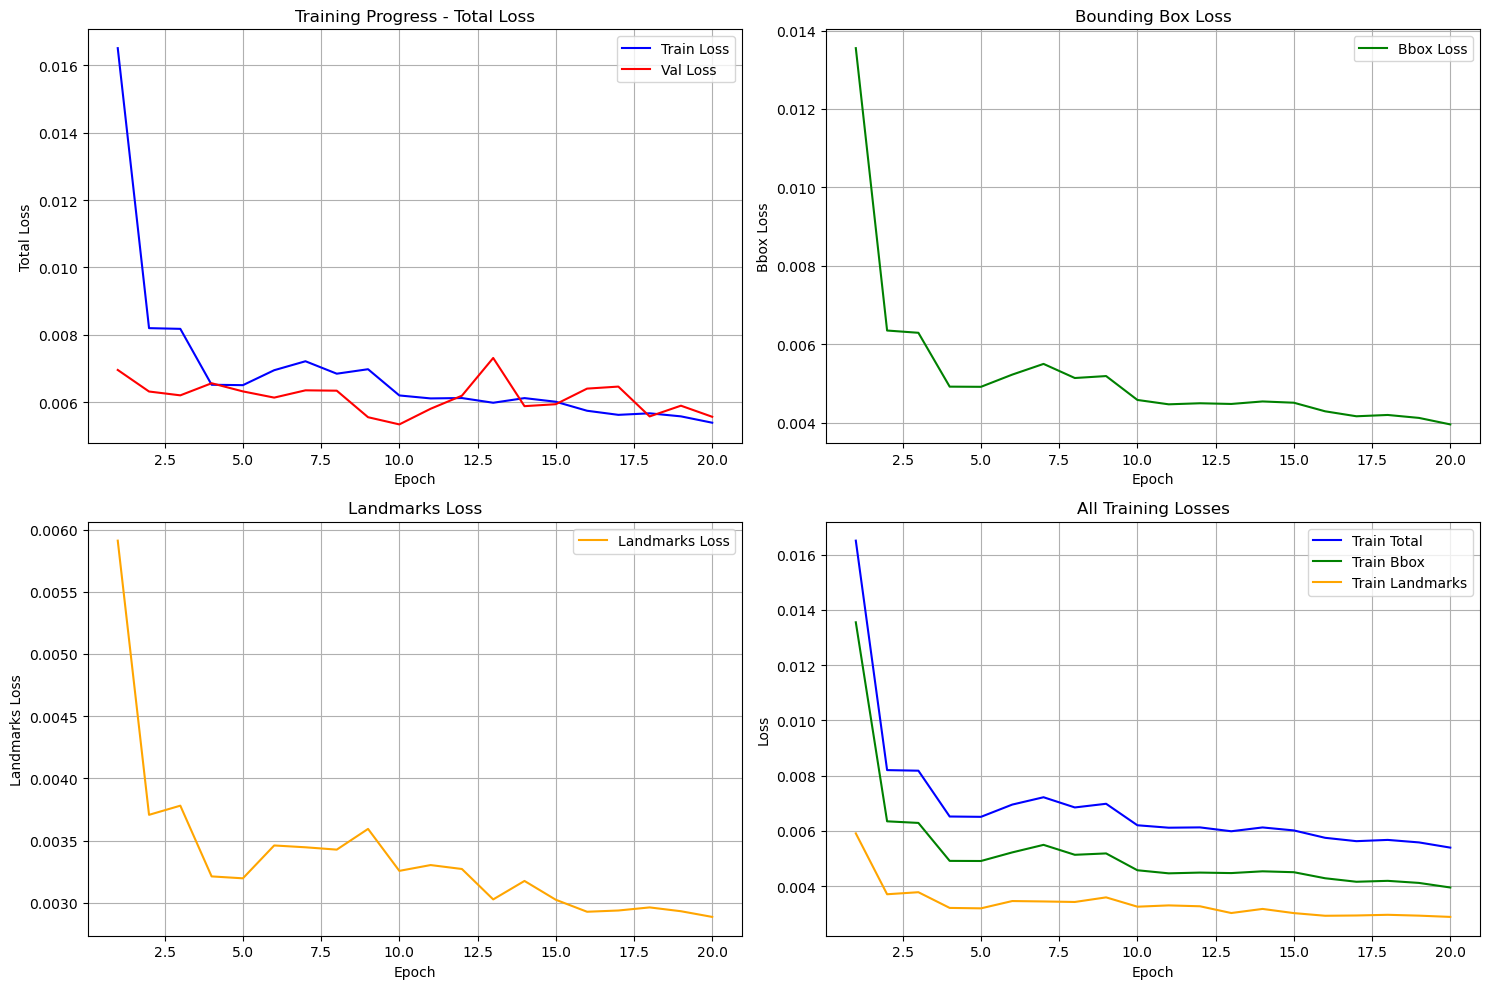

Training Summary:
- Total epochs: 20
- Final train loss: 0.0054
- Final val loss: 0.0056
- Best val loss: 0.0053
- Model saved to: face_detection_model.pth


In [11]:
# Plot training progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = list(range(1, len(train_losses) + 1))

# Plot total losses
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Training Progress - Total Loss')
ax1.legend()
ax1.grid(True)

# Plot bbox losses
ax2.plot(epochs, bbox_losses, label='Bbox Loss', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Bbox Loss')
ax2.set_title('Bounding Box Loss')
ax2.legend()
ax2.grid(True)

# Plot landmarks losses
ax3.plot(epochs, landmarks_losses, label='Landmarks Loss', color='orange')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Landmarks Loss')
ax3.set_title('Landmarks Loss')
ax3.legend()
ax3.grid(True)

# Plot combined losses
ax4.plot(epochs, train_losses, label='Train Total', color='blue')
ax4.plot(epochs, bbox_losses, label='Train Bbox', color='green')
ax4.plot(epochs, landmarks_losses, label='Train Landmarks', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.set_title('All Training Losses')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"Training Summary:")
print(f"- Total epochs: {len(train_losses)}")
print(f"- Final train loss: {train_losses[-1]:.4f}")
print(f"- Final val loss: {val_losses[-1]:.4f}")
print(f"- Best val loss: {min(val_losses):.4f}")
print(f"- Model saved to: face_detection_model.pth")

## Model Usage for Real-Time Video Processing

The trained model can now be used to detect faces in video streams:

```python
# Example for video frame face detection:
bbox, landmarks = detect_face(model, frame_image, device)
```

This completes the face detection part of your adaptive face-blur privacy system. The next steps would be:

1. **Temporal Tracking**: Use optical flow to track faces across frames
2. **Avatar Generation**: Create privacy-preserving avatars for each detected face
3. **Face Replacement**: Replace detected faces with consistent pseudonymous avatars